# Analysis

In this script I plot some variables against each other to answer the proposed question for this part of the project. Furthermore I will generate a correlation heatmap to control for all possible correlations.

Since the results already at this point cleary show that with the underlying data no cennection can be made one can conclude that there is based on the underlying data no observable relation between the parties finances and twitter activity.

For completion I also include linear regression models with the variables as y variables that show the most promising pearson correlations within the matrix. 
The linar models proof by coeeficents and p-values that no significant relation can be found.

In [335]:
import pickle
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [336]:
with open("master_df.obj", "rb") as f:
    df = pickle.load(f)

In [337]:
df.head()

,party,year,member_fee,mandate_holder_contributions_and_sim,donations_indiv,donations_legal,income_business_participations,income_other sources,income_events_sales,gov_funds,...,state per,EU per,year_int,replyCount_sum,retweetCount_sum,quoteCount_sum,tweet_count,neg_ave,pos_ave,neu_ave
30,BP,2010-01-01,42286.0,4160.00,164291.00,0.00,0.0,324.24,3360.50,112149.37,...,0.00,0.00,2010,0,11,0,376,0.109043,0.202128,0.688830
31,BP,2011-01-01,36836.0,225.00,148417.13,23.83,0.0,0.00,492.00,110099.80,...,0.00,0.00,2011,5,4,0,405,0.049383,0.251852,0.698765
32,BP,2012-01-01,35038.0,150.00,123311.56,1742.12,0.0,0.00,8487.50,105396.86,...,0.00,0.00,2012,3,35,0,394,0.078680,0.175127,0.746193
33,BP,2013-01-01,41006.0,200.00,173059.36,314.20,0.0,0.00,7904.07,160899.72,...,0.13,0.00,2013,5,53,0,277,0.086643,0.108303,0.805054
34,BP,2014-01-01,50097.0,2752.25,157088.95,6084.00,0.0,0.00,9307.92,174186.86,...,0.00,0.21,2014,15,124,0,269,0.092937,0.029740,0.877323


In [338]:
df.columns

Index(['party', 'year', 'member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'exp_corprate_activities', 'federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per', 'year_int',
       'replyCount_sum', 'retweetCount_sum', 'quoteCount_sum', 'tweet_count',
       'neg_ave', 'pos_ave', 'neu_ave'],
      dtype='object')

In [339]:
# drop "exp_corprate_activities" due to mostly NaNs

df.drop(columns=["exp_corprate_activities"],inplace=True)

In [340]:
df.columns

Index(['party', 'year', 'member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'federal state', 'state', 'EU', 'federal state per', 'state per',
       'EU per', 'year_int', 'replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count', 'neg_ave', 'pos_ave', 'neu_ave'],
      dtype='object')

#### scale financial numbers and twitter data
- we need to normalize certain variables since the range between the party is way to big!
- what normalization?
- use min-max sclaing within each party
- makes parties comparable, changes in relation to its capablities, otherwise comparing small and big parties would make no sense

In [341]:
col_to_transform = ['member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count']

# define new since ColumnTransformer puts all transformed variables to the left
col_scaled_df = ['member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net','replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count','party', 'year', 'federal state', 'state', 'EU', 'federal state per', 'state per',
       'EU per', 'year_int', 'neg_ave', 'pos_ave', 'neu_ave']

minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
col_scaler = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer , col_to_transform)
        ])


def scale_df_subset(df,party_list):
    df_scaled = pd.DataFrame(columns=col_scaled_df)
    for p in party_list:
        subset = df[df["party"]==p]
        subset_scaled = col_scaler.fit_transform(subset)
        df_scaled = df_scaled.append(pd.DataFrame(subset_scaled, columns=col_scaled_df))
    return df_scaled

In [342]:
scaled_df = scale_df_subset(df,df.party.unique())
scaled_df.reset_index(inplace=True,drop=True)

In [343]:
# correct datatype for the variables where needed
scaled_df[col_to_transform] = scaled_df[col_to_transform].astype(float)
scaled_df[["neg_ave","neu_ave","pos_ave"]] = scaled_df[["neg_ave","neu_ave","pos_ave"]].astype(float)

In [344]:
scaled_df.head(3)

,member_fee,mandate_holder_contributions_and_sim,donations_indiv,donations_legal,income_business_participations,income_other sources,income_events_sales,gov_funds,other_income,income_total,...,federal state,state,EU,federal state per,state per,EU per,year_int,neg_ave,pos_ave,neu_ave
0,0.211645,1.000000,0.849565,0.000000,0.0,1.0,0.346970,0.062173,1.000000,0.356815,...,0,0,0,0.0,0.0,0.0,2010,0.109043,0.202128,0.688830
1,0.052502,0.018703,0.591502,0.003917,0.0,0.0,0.032007,0.043302,0.964736,0.168180,...,0,0,0,0.0,0.0,0.0,2011,0.049383,0.251852,0.698765
2,0.000000,0.000000,0.183359,0.286345,0.0,0.0,0.909917,0.000000,0.646203,0.000000,...,0,0,0,0.0,0.0,0.0,2012,0.078680,0.175127,0.746193


In [345]:
scaled_df.columns #show column names for copy paste

Index(['member_fee', 'mandate_holder_contributions_and_sim', 'donations_indiv',
       'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'replyCount_sum', 'retweetCount_sum', 'quoteCount_sum',
       'tweet_count', 'party', 'year', 'federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per', 'year_int', 'neg_ave',
       'pos_ave', 'neu_ave'],
      dtype='object')

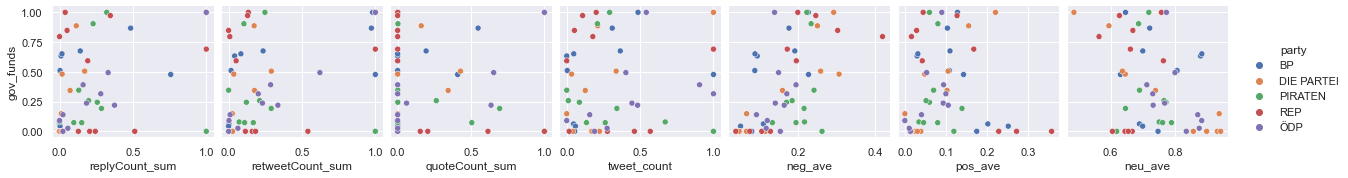

In [346]:
# original question was specifically aiming at goverment fund:

# party and year as hue
twitter_vars = ['replyCount_sum', 'retweetCount_sum', 'quoteCount_sum','tweet_count','neg_ave','pos_ave', 'neu_ave']
sns.pairplot(scaled_df,x_vars=twitter_vars,y_vars=['gov_funds'], hue="party")


In [347]:
import pandas as pd

finance_vars = ['member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total','exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net']

# set up correlationmatrix between twitter and finance variables
df1 = scaled_df.loc[:,twitter_vars]
df2 = scaled_df.loc[:,finance_vars]
corr_df = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr(method="pearson").loc['df1', 'df2']

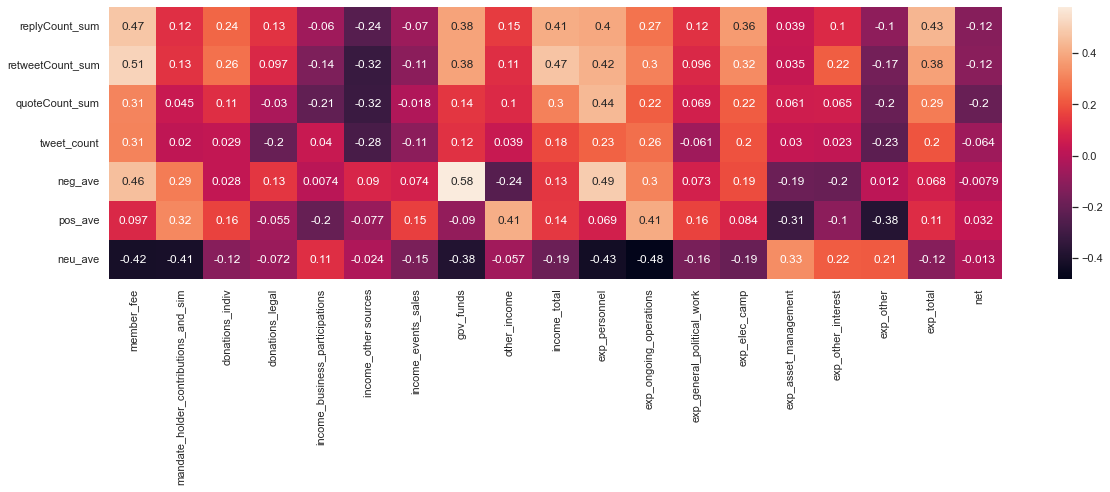

In [348]:
# plot correlation heatmap
sns.set(rc={'figure.figsize':(20,5)})
sns.heatmap(corr_df, annot = True)

plt.show()

In [349]:
# to not miss any suprising correlations i first checked all variables
## for the further analysis I exclude certain variables based pn research aim 

## twitter_data > drop: neu_ave - not much information for interpretation

## for finance drop columns with no corr above 0.4(below -0.4) apart neu:


corr_df_2 = corr_df.drop(labels=["neu_ave"],axis=0)
col_to_drop = []
for col_name in corr_df_2.columns:
    if max(corr_df_2[col_name]) < 0.4 and min(corr_df_2[col_name]) > -0.4:
        col_to_drop.append(col_name)

corr_df_2 = corr_df_2.drop(columns=col_to_drop)

In [350]:
corr_df_2

,member_fee,gov_funds,other_income,income_total,exp_personnel,exp_ongoing_operations,exp_total
replyCount_sum,0.474500,0.384685,0.149006,0.408276,0.397717,0.269481,0.431883
retweetCount_sum,0.510649,0.382313,0.112369,0.468636,0.421348,0.302457,0.379243
quoteCount_sum,0.308733,0.135233,0.103036,0.301658,0.442500,0.220871,0.286486
tweet_count,0.305622,0.120696,0.039299,0.176599,0.229523,0.257810,0.200356
neg_ave,0.458585,0.580108,-0.242812,0.134959,0.492551,0.304985,0.067967
pos_ave,0.097493,-0.089981,0.414121,0.140169,0.068905,0.405511,0.110760


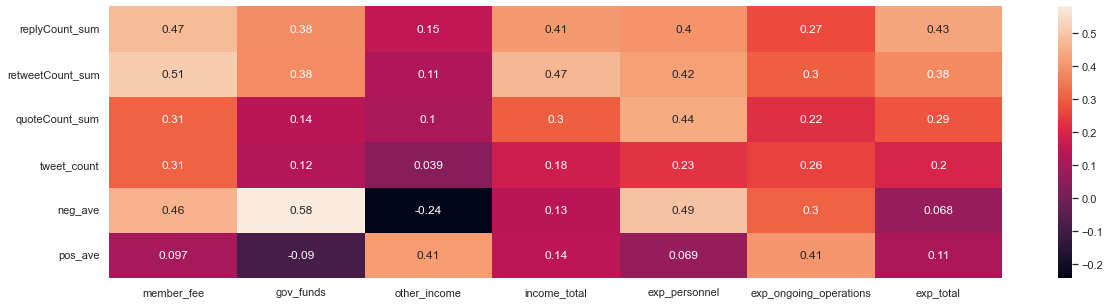

In [351]:

sns.set(rc={'figure.figsize':(20,5)})

sns.heatmap(corr_df_2, annot = True)

plt.show()

In [352]:
# some basic visualizatons of intersting relations

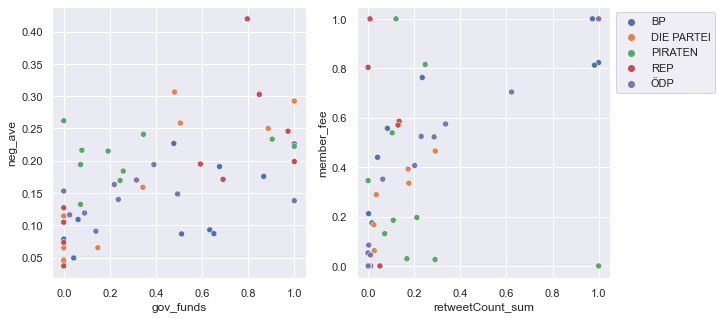

In [353]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.scatterplot(data=scaled_df,x="gov_funds",y="neg_ave", hue="party",ax=axs[0])
axs[0].get_legend().remove()

sns.scatterplot(data=scaled_df,x="retweetCount_sum",y="member_fee", hue="party",ax=axs[1])
axs[1].legend(loc="upper left", bbox_to_anchor=(1, 1))


# set up linear regression models for each twitter attribute to investigate possible relations further

In [354]:
# print vars to keep overview
print(list(corr_df_2.index))
print(list(corr_df_2.columns))
print(list(scaled_df.columns))

['replyCount_sum', 'retweetCount_sum', 'quoteCount_sum', 'tweet_count', 'neg_ave', 'pos_ave']
['member_fee', 'gov_funds', 'other_income', 'income_total', 'exp_personnel', 'exp_ongoing_operations', 'exp_total']
['member_fee', 'mandate_holder_contributions_and_sim', 'donations_indiv', 'donations_legal', 'income_business_participations', 'income_other sources', 'income_events_sales', 'gov_funds', 'other_income', 'income_total', 'exp_personnel', 'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp', 'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total', 'net', 'replyCount_sum', 'retweetCount_sum', 'quoteCount_sum', 'tweet_count', 'party', 'year', 'federal state', 'state', 'EU', 'federal state per', 'state per', 'EU per', 'year_int', 'neg_ave', 'pos_ave', 'neu_ave']


In [355]:
# set up preprocessing pipeline

def load_reg_df(df,y_name):
    '''
    retuns y and X for linear regression statsmodel
    '''
    cols = ['federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per']+list(corr_df_2.columns)
    
    df = df.dropna(axis=0,inplace=False)
    y = df[y_name]
    X = df[cols]
    
    return y,X

In [356]:
# set up empty dataframe for p_value matrix
df_pvalues = pd.DataFrame(columns=["const",'federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per']+list(corr_df_2.columns))

#### replyCount_sum

In [357]:
y,X = load_reg_df(scaled_df,"replyCount_sum")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()
df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()


C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         replyCount_sum   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     3.291
Date:                Mon, 17 Jan 2022   Prob (F-statistic):            0.00400
Time:                        18:27:11   Log-Likelihood:                 11.132
No. Observations:                  42   AIC:                             5.737
Df Residuals:                      28   BIC:                             30.06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.2095      0.116     -1.800      0.083      -0.448       0.029
federal state              0.0530      0.033      1.615      0.118      -0.014       0.120
state                      0.2038      0.132      1.545      0.134      -0.066       0.474
EU                         0.4628      0.173      2.669      0.013       0.108       0.818
federal state per         -0.0409      0.039     -1.035      0.310      -0.122       0.040
state per                 -0.1272      0.140     -0.907      0.372      -0.414       0.160
EU per                    -0.0107      0.141     -0.076      0.940      -0.300       0.279
member_fee                 0.4950      0.209      2.371      0.025       0.067       0.923
gov_funds                 -0.1730      0.191     -0.906      0.373      -0.564       0.218
other_income               0.0591      0.127      0.464      0.646      -0.202       0.320
income_total               0.1081      0.203      0.532      0.599      -0.308       0.524
exp_personnel             -0.0151      0.152     -0.099      0.922      -0.327       0.297
exp_ongoing_operations     0.2073      0.129      1.609      0.119      -0.057       0.471
exp_total                 -0.1379      0.183     -0.753      0.458      -0.513       0.237
==============================================================================
Omnibus:                        0.960   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.272
Skew:                           0.064   Prob(JB):                        0.873
Kurtosis:                       3.373   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### retweetCount_sum

In [358]:
y,X = load_reg_df(scaled_df,"retweetCount_sum")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()


C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       retweetCount_sum   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     2.641
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0152
Time:                        18:27:11   Log-Likelihood:                 4.1459
No. Observations:                  42   AIC:                             19.71
Df Residuals:                      28   BIC:                             44.04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.2114      0.137     -1.538      0.135      -0.493       0.070
federal state              0.0578      0.039      1.492      0.147      -0.022       0.137
state                      0.1546      0.156      0.992      0.329      -0.165       0.474
EU                         0.3818      0.205      1.865      0.073      -0.038       0.801
federal state per         -0.0813      0.047     -1.743      0.092      -0.177       0.014
state per                 -0.1788      0.166     -1.080      0.289      -0.518       0.160
EU per                    -0.0607      0.167     -0.364      0.719      -0.403       0.281
member_fee                 0.5868      0.247      2.380      0.024       0.082       1.092
gov_funds                 -0.3835      0.225     -1.701      0.100      -0.845       0.078
other_income               0.0067      0.150      0.045      0.965      -0.301       0.315
income_total               0.3679      0.240      1.534      0.136      -0.123       0.859
exp_personnel              0.0052      0.180      0.029      0.977      -0.363       0.374
exp_ongoing_operations     0.2619      0.152      1.722      0.096      -0.050       0.574
exp_total                 -0.0903      0.216     -0.417      0.680      -0.534       0.353
==============================================================================
Omnibus:                        0.926   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.568
Skew:                           0.285   Prob(JB):                        0.753
Kurtosis:                       3.009   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### quoteCount_sum

In [359]:
y,X = load_reg_df(scaled_df,"quoteCount_sum")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         quoteCount_sum   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     1.933
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0702
Time:                        18:27:11   Log-Likelihood:                0.34794
No. Observations:                  42   AIC:                             27.30
Df Residuals:                      28   BIC:                             51.63
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.2315      0.150     -1.538      0.135      -0.540       0.077
federal state              0.0839      0.042      1.979      0.058      -0.003       0.171
state                      0.2470      0.171      1.448      0.159      -0.102       0.596
EU                         0.4048      0.224      1.806      0.082      -0.054       0.864
federal state per         -0.0805      0.051     -1.576      0.126      -0.185       0.024
state per                 -0.2147      0.181     -1.185      0.246      -0.586       0.156
EU per                    -0.0682      0.183     -0.373      0.712      -0.443       0.306
member_fee                 0.3518      0.270      1.304      0.203      -0.201       0.905
gov_funds                 -0.3491      0.247     -1.415      0.168      -0.855       0.156
other_income               0.0646      0.165      0.392      0.698      -0.273       0.402
income_total               0.3524      0.263      1.343      0.190      -0.185       0.890
exp_personnel              0.1736      0.197      0.881      0.386      -0.230       0.577
exp_ongoing_operations     0.2136      0.167      1.283      0.210      -0.128       0.555
exp_total                 -0.2103      0.237     -0.888      0.382      -0.696       0.275
==============================================================================
Omnibus:                        0.489   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.186
Skew:                           0.162   Prob(JB):                        0.911
Kurtosis:                       3.036   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### tweet_count

In [360]:
y,X = load_reg_df(scaled_df,"tweet_count")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            tweet_count   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     1.981
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0632
Time:                        18:27:11   Log-Likelihood:                 4.0075
No. Observations:                  42   AIC:                             19.99
Df Residuals:                      28   BIC:                             44.31
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1735      0.138      1.258      0.219      -0.109       0.456
federal state             -0.0010      0.039     -0.026      0.980      -0.081       0.079
state                      0.0829      0.156      0.531      0.600      -0.237       0.403
EU                         0.1986      0.205      0.967      0.342      -0.222       0.620
federal state per         -0.0847      0.047     -1.811      0.081      -0.181       0.011
state per                  0.0620      0.166      0.374      0.712      -0.278       0.402
EU per                     0.2286      0.168      1.364      0.183      -0.115       0.572
member_fee                 0.6672      0.247      2.697      0.012       0.160       1.174
gov_funds                 -0.5660      0.226     -2.502      0.018      -1.029      -0.103
other_income              -0.1271      0.151     -0.842      0.407      -0.436       0.182
income_total               0.0146      0.241      0.061      0.952      -0.478       0.507
exp_personnel             -0.0452      0.181     -0.250      0.804      -0.415       0.325
exp_ongoing_operations     0.2158      0.153      1.414      0.168      -0.097       0.528
exp_total                 -0.0494      0.217     -0.228      0.822      -0.494       0.395
==============================================================================
Omnibus:                        4.276   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                3.063
Skew:                           0.608   Prob(JB):                        0.216
Kurtosis:                       3.524   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### neg_ave

In [361]:
y,X = load_reg_df(scaled_df,"neg_ave")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                neg_ave   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     4.850
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           0.000229
Time:                        18:27:11   Log-Likelihood:                 72.887
No. Observations:                  42   AIC:                            -117.8
Df Residuals:                      28   BIC:                            -93.45
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1258      0.027      4.703      0.000       0.071       0.181
federal state              0.0019      0.008      0.252      0.803      -0.014       0.017
state                      0.0094      0.030      0.311      0.758      -0.053       0.072
EU                         0.0249      0.040      0.624      0.538      -0.057       0.107
federal state per          0.0094      0.009      1.036      0.309      -0.009       0.028
state per                  0.0324      0.032      1.006      0.323      -0.034       0.098
EU per                     0.0133      0.033      0.410      0.685      -0.053       0.080
member_fee                 0.0500      0.048      1.043      0.306      -0.048       0.148
gov_funds                  0.1592      0.044      3.629      0.001       0.069       0.249
other_income              -0.0404      0.029     -1.380      0.179      -0.100       0.020
income_total              -0.1628      0.047     -3.489      0.002      -0.258      -0.067
exp_personnel              0.0752      0.035      2.147      0.041       0.003       0.147
exp_ongoing_operations     0.0407      0.030      1.374      0.180      -0.020       0.101
exp_total                 -0.0755      0.042     -1.793      0.084      -0.162       0.011
==============================================================================
Omnibus:                        1.562   Durbin-Watson:                   2.223
Prob(Omnibus):                  0.458   Jarque-Bera (JB):                0.816
Skew:                           0.310   Prob(JB):                        0.665
Kurtosis:                       3.285   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### pos_ave

In [362]:
y,X = load_reg_df(scaled_df,"pos_ave")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pos_ave   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1.808
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0923
Time:                        18:27:11   Log-Likelihood:                 72.016
No. Observations:                  42   AIC:                            -116.0
Df Residuals:                      28   BIC:                            -91.71
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0271      0.027      0.991      0.330      -0.029       0.083
federal state             -0.0003      0.008     -0.042      0.967      -0.016       0.015
state                      0.0425      0.031      1.371      0.181      -0.021       0.106
EU                         0.0099      0.041      0.243      0.810      -0.073       0.093
federal state per         -0.0035      0.009     -0.376      0.710      -0.022       0.015
state per                 -0.0493      0.033     -1.497      0.145      -0.117       0.018
EU per                     0.0260      0.033      0.783      0.440      -0.042       0.094
member_fee                -0.0111      0.049     -0.226      0.823      -0.111       0.089
gov_funds                  0.0266      0.045      0.593      0.558      -0.065       0.118
other_income               0.0779      0.030      2.606      0.014       0.017       0.139
income_total               0.0203      0.048      0.426      0.673      -0.077       0.118
exp_personnel             -0.0202      0.036     -0.564      0.577      -0.093       0.053
exp_ongoing_operations     0.0865      0.030      2.861      0.008       0.025       0.148
exp_total                 -0.0716      0.043     -1.665      0.107      -0.160       0.016
==============================================================================
Omnibus:                        3.638   Durbin-Watson:                   1.379
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                2.432
Skew:                           0.497   Prob(JB):                        0.296
Kurtosis:                       3.632   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [363]:
df_pvalues

,const,federal state,state,EU,federal state per,state per,EU per,member_fee,gov_funds,other_income,income_total,exp_personnel,exp_ongoing_operations,exp_total
0,0.082671,0.117510,0.133577,0.012522,0.309568,0.371937,0.940273,0.024850,0.372604,0.646072,0.598627,0.921564,0.118749,0.458019
1,0.135386,0.146836,0.329487,0.072752,0.092220,0.289425,0.718874,0.024359,0.099972,0.964532,0.136244,0.976965,0.096175,0.679766
2,0.135199,0.057766,0.158645,0.081684,0.126160,0.246010,0.712095,0.202966,0.168151,0.697929,0.190170,0.385872,0.210143,0.382192
3,0.218896,0.979603,0.599867,0.341907,0.080879,0.711548,0.183402,0.011706,0.018455,0.406922,0.951888,0.804113,0.168487,0.821635
4,0.000062,0.802691,0.757748,0.537818,0.309245,0.323235,0.685116,0.305859,0.001124,0.178510,0.001621,0.040637,0.180494,0.083781
5,0.330346,0.966684,0.181114,0.810056,0.709601,0.145465,0.440377,0.823103,0.557856,0.014496,0.673062,0.577455,0.007907,0.107111


In [364]:
df_pvalues.index = ['replyCount_sum', 'retweetCount_sum', 'quoteCount_sum', 'tweet_count',
       'neg_ave', 'pos_ave']

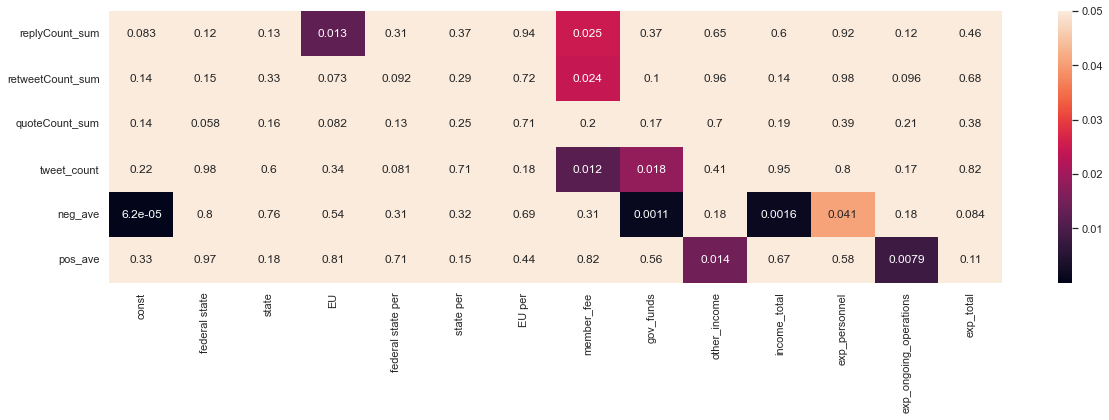

In [365]:
#plot pvalue heatmap, color only significant values (<0.05)
sns.set(rc={'figure.figsize':(20,5)})
pv_fig = sns.heatmap(df_pvalues, annot = True, vmax=0.05)

plt.show()

## Plot  significant relations
- replyCount_sum , EU
- replyCount_sum, member_fee
- retweetCount_sum, member_fee
- tweet_count, memeber_fee
- tweet_count, gov_funds
- neg_ave, gov_funds
- neg_ave, income_total
- neg_ave, exp_personnel
- pos_ave, other_income
- pos_ave, exp_ongoing_operations


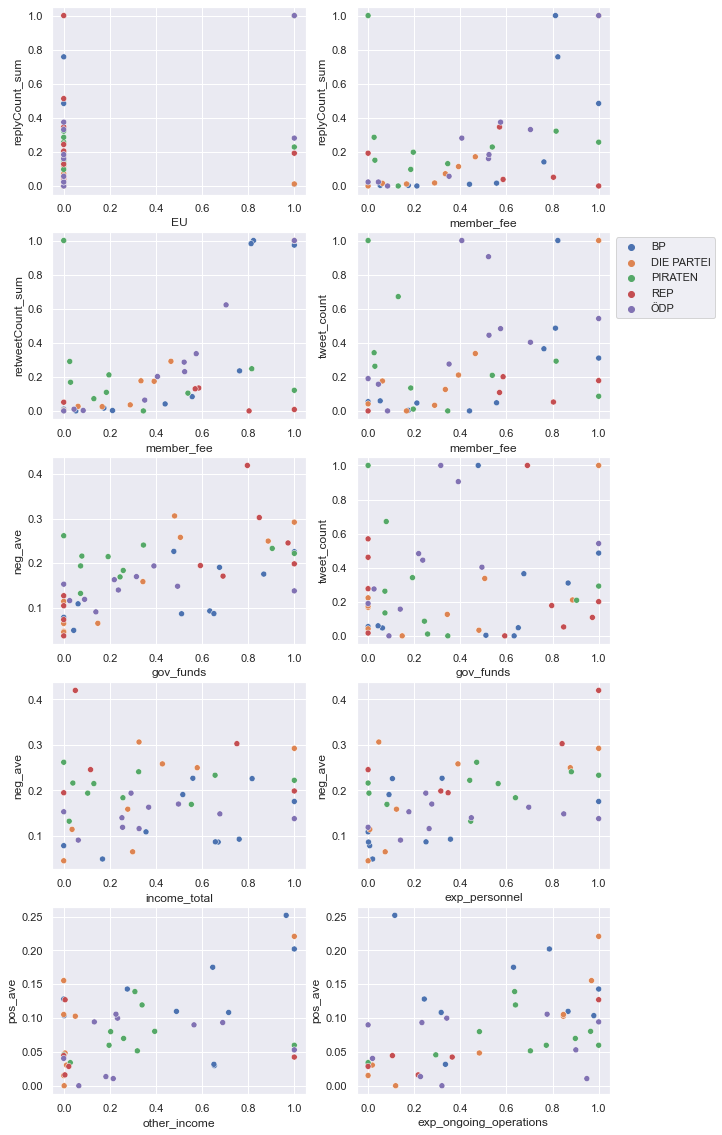

In [366]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(10,20))

sns.scatterplot(data=scaled_df,x="EU",y="replyCount_sum",hue="party",ax=axs[0,0])
axs[0,0].get_legend().remove()
sns.scatterplot(data=scaled_df, y="replyCount_sum",x="member_fee",hue="party",ax=axs[0,1])
axs[0,1].get_legend().remove()

sns.scatterplot(data=scaled_df, y="retweetCount_sum",x="member_fee",hue="party",ax=axs[1,0])
axs[1,0].get_legend().remove()

sns.scatterplot(data=scaled_df, y="tweet_count",x="member_fee",hue="party",ax=axs[1,1])
axs[1,1].legend(loc="upper left", bbox_to_anchor=(1, 1))

sns.scatterplot(data=scaled_df, y="neg_ave",x="gov_funds", hue="party",ax=axs[2,0])
axs[2,0].get_legend().remove()

sns.scatterplot(data=scaled_df, y="tweet_count",x="gov_funds", hue="party",ax=axs[2,1])
axs[2,1].get_legend().remove()

sns.scatterplot(data=scaled_df, y="neg_ave",x="income_total",hue="party",ax=axs[3,0])
axs[3,0].get_legend().remove()

sns.scatterplot(data=scaled_df, y="neg_ave",x="exp_personnel",hue="party",ax=axs[3,1])
axs[3,1].get_legend().remove()

sns.scatterplot(data=scaled_df, y="pos_ave",x="other_income",hue="party",ax=axs[4,0])
axs[4,0].get_legend().remove()

sns.scatterplot(data=scaled_df, y="pos_ave",x="exp_ongoing_operations",hue="party",ax=axs[4,1])
axs[4,1].get_legend().remove()




In [219]:
## last step: Controll for party and Year as possible confunding variables
# how?

# print p_value matrix per Party and per year?
### rank deficit for parties (max 10 observations per party), less per year

# y_s = ['replyCount_sum', 'retweetCount_sum', 'quoteCount_sum', 'tweet_count',
#        'neg_ave', 'pos_ave']

# def generate_pv_matrix(y_s,group_list,classifying_var):
    
#     for group in group_list:
#         print(group)
#         df_sub = scaled_df[scaled_df[classifying_var] == group]
        
        
#         df_pvalues = pd.DataFrame(columns=["const",'federal state', 'state', 'EU',
#        'federal state per', 'state per', 'EU per']+list(corr_df_2.columns))
        
        
        
#         for v in y_s:
#             y,X = load_reg_df(df_sub,v)
#             X = sm.add_constant(X)
                        
#             print(X)
#             model = sm.OLS(y,X.astype(float))
            
#             results = model.fit()
            
            
#             df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
            
            
#         df_pvalues.index = y_s
                
#         sns.set(rc={'figure.figsize':(20,5)})
#         sns.heatmap(df_pvalues, annot = True, vmax=0.05)
#         fig.show()
